# Idea
Do some Plotting of singular features

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

In [2]:
from py_dataset import get_all_files_df
from py_dataset import read_in_files
from py_dataset import feature_plotting

In [3]:
data_path = Path('/media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/')
assert data_path.exists()

In [4]:
df = get_all_files_df.main(data_path)
df.head(1)

txt file found, will drop /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device1/3_thetick_4h/collections.txt
txt file found, will drop /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device2/1_normal/note.txt
                                           file_path
0  /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/...
RangeIndex(start=0, stop=622, step=1)
filetype
csv    530
zip     92
Name: count, dtype: int64
                                           file_path filetype  filesize_bytes
0  /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/...      csv           49419
feature_family
SYS_data        92
KERN_data       91
FLS_data        91
RES_data        91
block_data      91
network_data    91
entropy_data    75
Name: count, dtype: int64


,file_path,filetype,filesize_bytes,researcher_name,device_name,experiment,feature_family,file_name,device
0,/media//DC/MAP_CreationOfNewDatasetsForDFL/...,csv,49419,Heqing,device1,1_normal,block_data,e4_5f_01_68_35_e6.csv,Heqing_device1


#### Get Single data
* device = Heqing_device2 => most data
* go through all features of each feature_family
    * for one 
        1. First: Sum up over all experiments/Malwares/labels first
        2. Then: Then only specific attack in comparison?
            * each column: normalize the data
            * plot boxplot: distribution

In [5]:
single_dev = df[df["device"] == "Heqing_device2"]
assert len(single_dev["device"].unique()) == 1

In [6]:
single_dev_single_data_source = single_dev[single_dev["feature_family"] == "entropy_data"]
assert len(single_dev_single_data_source["feature_family"].unique()) == 1
single_dev_single_data_source.shape

(19, 9)

In [7]:
vectors = read_in_files.get_all_columns_from_single_data_source_for_csv_files(single_dev_single_data_source)

In [8]:
print("len:", len(vectors))
vectors.columns

len: 101606


Index(['file_path', 'action', 'entropy', 'experiment'], dtype='object')

In [14]:
non_numeric_cols = vectors.select_dtypes(exclude=['number']).columns.tolist()
non_numeric_cols.remove("experiment")
for col in non_numeric_cols:
    vectors[col] = pd.to_numeric(vectors[col])
non_numeric_cols

ValueError: Unable to parse string "/tmp/perf-vdso.so-mDAroA" at position 0

In [16]:
vectors.reset_index(inplace=True, drop=True)  # drop: "timestamp"
# non_numeric_cols = vectors.select_dtypes(exclude=['number']).columns.tolist()
# non_numeric_cols.remove("experiment")
# for col in non_numeric_cols:
#     vectors[col] = pd.to_numeric(vectors[col])
# print("non numeric cols: ", non_numeric_cols)

cols_to_exclude_from_scaling = ["experiment", "action", "file_path"]

vectors_scaled = feature_plotting.minmax_scale_features(vectors,
                                                        remove_outliers_iqr_all_columns=False,
                                                        cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)

vectors_robust_scaled = feature_plotting.minmax_scale_features(vectors,
                                                               remove_outliers_iqr_all_columns=True,
                                                               cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)

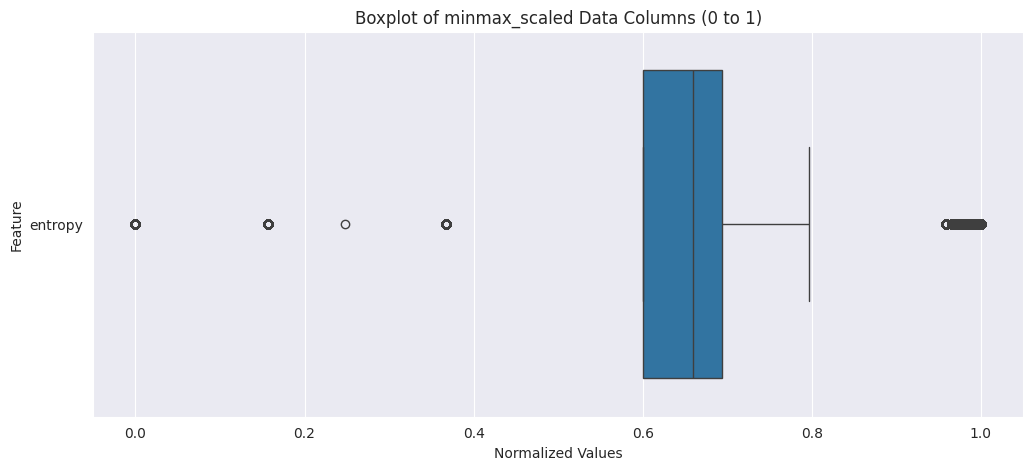

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.boxplot(data=vectors_scaled, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

plt.ylabel('Feature')
# plt.xticks(rotation=45)
plt.xlabel('Normalized Values')

plt.title('Boxplot of minmax_scaled Data Columns (0 to 1)')
plt.show()

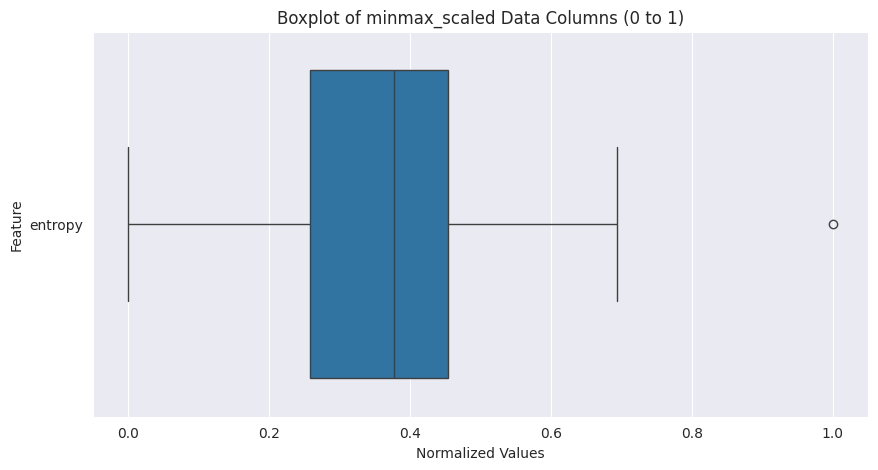

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=vectors_robust_scaled, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

plt.ylabel('Feature')
# plt.xticks(rotation=45)
plt.xlabel('Normalized Values')

plt.title('Boxplot of minmax_scaled Data Columns (0 to 1)')
plt.show()

In [21]:
len(vectors_scaled.columns)

4

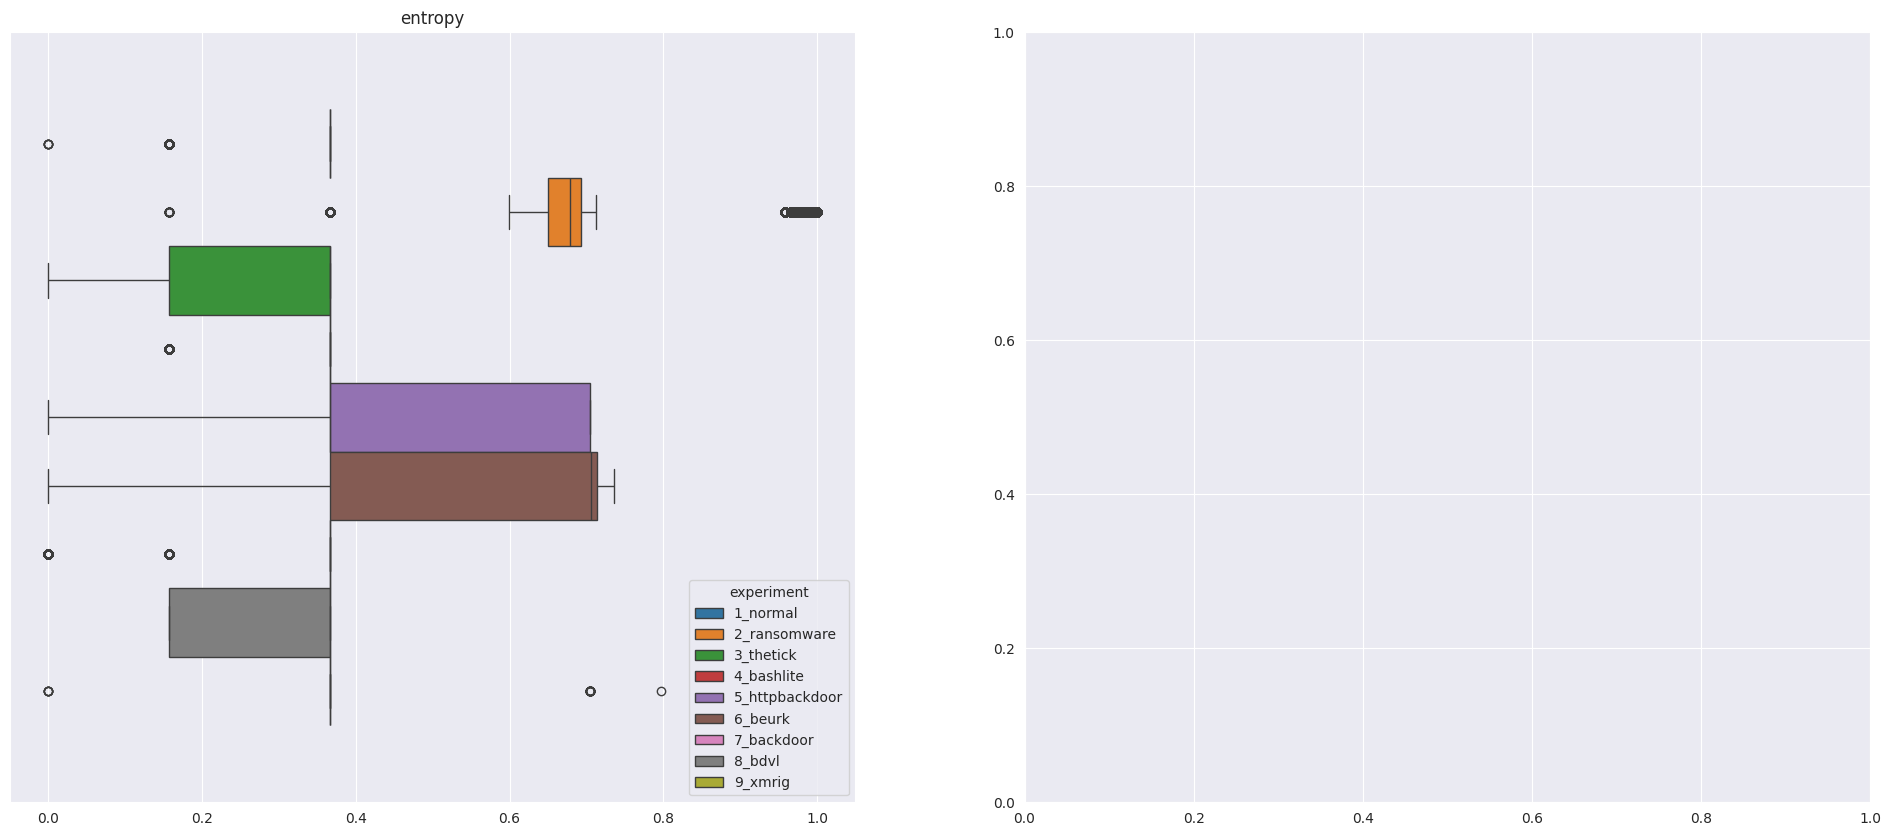

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 8))
# sns.boxplot(data=vectors_scaled, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

fig, axs = plt.subplots(1, 2, figsize=(24, 10))

# Flatten the axes for easier indexing
axs = axs.flatten()

# labels = vectors_scaled["experiment"].unique()
# handles, labels = axs[0].get_legend_handles_labels()

# Plot each column as a boxplot
for i, column in enumerate(vectors_scaled.columns):
    if column in cols_to_exclude_from_scaling:
        continue

    sns.boxplot(data=vectors_scaled, x=column, ax=axs[i], hue="experiment", native_scale=True, orient="h",
                legend=True)
    axs[i].set_title(f'{column}')
    axs[i].set_xlabel('')

# axs[1].legend(['Survived', 'Not Survived'])

# plt.ylabel('Columns')
# plt.xticks(rotation=45)
# plt.xlabel('Values')
# plt.legend(loc='upper right')
# plt.tight_layout()
# labels = vectors_scaled["experiment"].unique()
# # handles, labels = axs[0].get_legend_handles_labels()
# plt.legend(labels, loc='upper right')
plt.show()

#### Make a narrow dataset

In [25]:
vectors_scaled.head(1)

,entropy,experiment,action,file_path
0,0.366879,1_normal,CREATE,/tmp/perf-vdso.so-mDAroA


In [28]:
narrow_df = pd.melt(
    vectors_scaled.drop(columns=["action", "file_path"], inplace=False), id_vars=['experiment'], var_name='x',
    value_name='y')
narrow_df.head(1)

,experiment,x,y
0,1_normal,entropy,0.366879


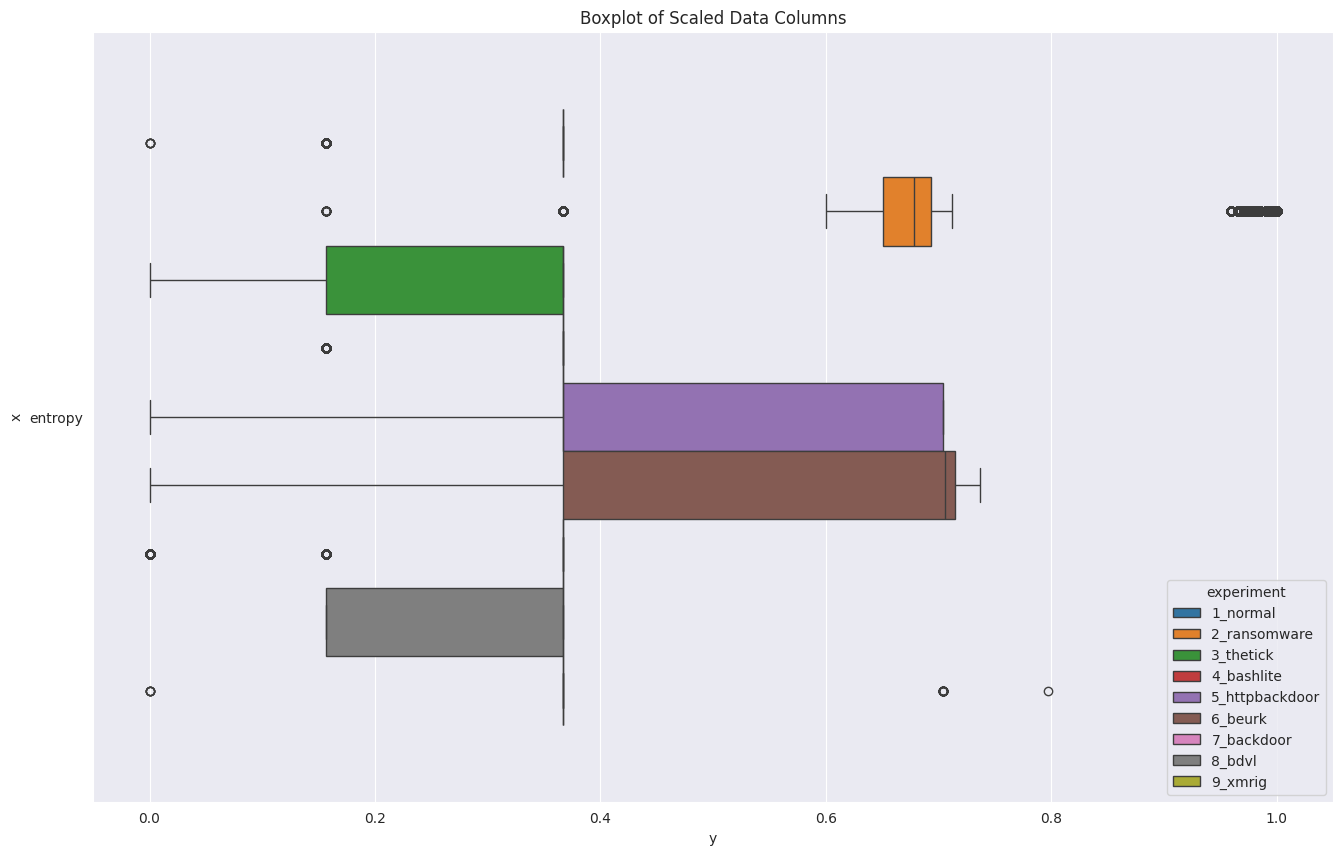

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
# sns.boxplot(data=narrow_df, x="x", y="y"
# hue = "experiment")  # x="class", y="age", legend="full", native_scale=True,
sns.boxplot(data=narrow_df, x="y", y="x", orient="h",
            hue="experiment")

# plt.ylabel('Columns')
# # plt.xticks(rotation=45)
# plt.xlabel('Values')

plt.title('Boxplot of Scaled Data Columns')
plt.show()

In [56]:
assert False, "Stop here, doesnt make sense anyway"

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 90))
# sns.boxplot(data=narrow_df, x="experiment", y="y",  #orient="h",
#             hue="x")  # x="class", y="age", legend="full", native_scale=True,
sns.boxplot(data=narrow_df, x="y", y="x", orient="h",
            hue="experiment")

# plt.ylabel('Columns')
# # plt.xticks(rotation=45)
# plt.xlabel('Values')

plt.title('Boxplot of Scaled Data Columns')
plt.show()

AssertionError: Stop here, doesnt make sense anyway